# Wine Inventory

There are a collection of wines that have been cataloged by wines we have purchased and consumed over the past few years: "onShelf.csv". The goal of this analysis is to clean up the inventory, observe the factors that contribute most to how much a wine is enjoyed, and use them to predict the rating for wines we have not tasted yet.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [80]:
# creating a single dataset of all the wines

headers = ['Location Code', 'Location', 'Vintage', 'Region', 'Wine Name', 'Grape/Blend', 'Quantity', 
           'Rating', 'Unit Purchase Price', 'Type', 'Purchase Date']

df = pd.read_csv('onShelf.csv', names=headers, header=0, index_col=False)

df = df.reset_index(drop=True)

In [81]:
df.head()

,Location Code,Location,Vintage,Region,Wine Name,Grape/Blend,Quantity,Rating,Unit Purchase Price,Type,Purchase Date
0,TL1,Bar,2017.0,France,Domaine Lafage Bastide Miraflors Côtes du Rous...,Syrah/Granache,1.0,NaN,$14.25,Red,11/7/2020
1,TL2,Bar,2017.0,Italy,Scaia Paradiso,Corvina/Rondinella/Cabernet,1.0,4.0,$19.00,Red,5/30/2020
2,TL3,Bar,2016.0,Spain,Nubori Crianza Rioja,Tempranillo,1.0,4.0,$16.00,Red,11/23/2019
3,TL3,Bar,2016.0,Spain,Cyan Toro,Tempranillo,1.0,NaN,$16.50,Red,11/7/2020
4,TL4,Bar,2016.0,California,Sterling,Merlot,1.0,4.0,$-,Red,NaN


### Handling Missing Values

In [82]:
df.drop(df[df['Wine Name'].isna() == True].index, inplace=True)

In [83]:
df.isna().sum()

Location Code           0
Location                0
Vintage                 3
Region                  0
Wine Name               0
Grape/Blend             0
Quantity                0
Rating                 37
Unit Purchase Price     0
Type                    0
Purchase Date          12
dtype: int64

In [84]:
df['Vintage'] = df['Vintage'].fillna(0)

In [85]:
df = df.astype({'Quantity':'int', 'Vintage':'int'}) 

In [86]:
df.loc[68, 'Quantity'] = 0 # Mara - Drank last bottle
df.loc[23, 'Quantity'] = 1 # Chateau Labastide Orliac drank one

### Splitting and Encoding

In [87]:
data = df[['Vintage', 'Region', 'Grape/Blend', 'Type', 'Rating']]

In [88]:
# encoding
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

encoder = ce.OneHotEncoder(cols=['Region', 'Grape/Blend', 'Type'], use_cat_names=True, 
                           handle_unknown='return_nan',return_df=True)

data = encoder.fit_transform(data)

C:\Users\Grace\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [89]:
train_data = data.dropna(axis=0)
test_data = data[data['Rating'].isna()]

In [90]:
# splitting the test/train sets
X_train = np.array(train_data.iloc[:,:-1].astype('int'))
y_train = np.array(train_data.iloc[:,-1])

X_test = np.array(test_data.iloc[:,:-1].astype('int'))

### Updating Ratings

In [91]:
def update_rating(index, new_rating):
    updated = df.iloc[index,7] = new_rating
    return updated

In [92]:
update_rating(18,5)
update_rating(22,4)

4

### Visualization

<AxesSubplot:xlabel='Vintage', ylabel='Rating'>

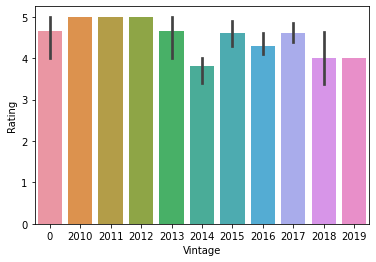

In [93]:
import seaborn as sns
%matplotlib inline 

sns.barplot(x='Vintage', y='Rating', data=df)

seaborn.axisgrid.FacetGrid

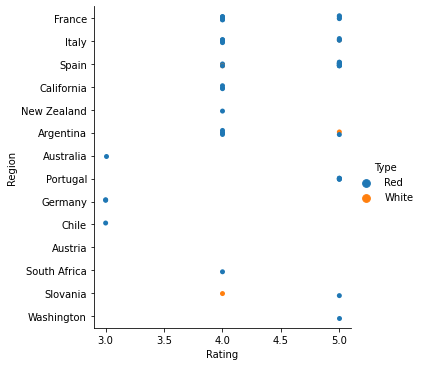

In [94]:
fig_lvl = sns.catplot(data=df, x='Rating', y='Region', hue='Type')
type(fig_lvl)

seaborn.axisgrid.FacetGrid

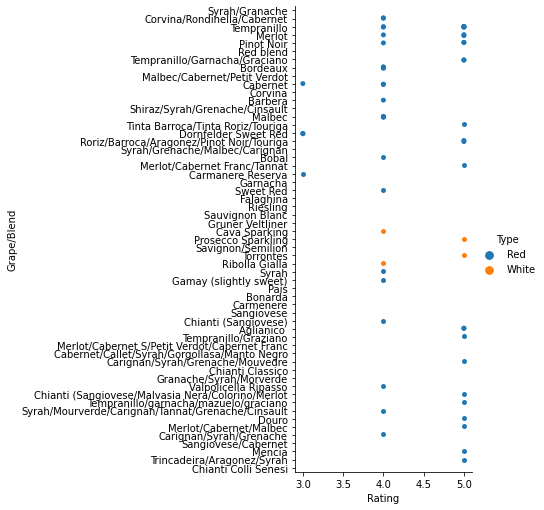

In [95]:
fig_blend = sns.catplot(data=df, x='Rating', y='Grape/Blend', hue='Type', height=7, aspect=1)
type(fig_blend)

### Creating the Model

In [96]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [97]:
y_pred = regressor.predict(X_test)

## Best Predicted Wine

Getting the best predicted value and finding the wine with that predicted rating.

In [98]:
y_pred.max()

4.96

In [99]:
# creating a dataframe with the predicted ratings
pred_dict = {'pred_rating':y_pred}
pred_df = pd.DataFrame(pred_dict)
pred_df.head()

,pred_rating
0,4.310000
1,4.220881
2,4.220000
3,3.970000
4,4.340000


Creating a dataframe containing the rows with the original wine information in which the rating needed to be predicted.

In [100]:
info = df[df['Rating'].isna()]
info = info.dropna(axis=1)
info = info.reset_index(drop=True)

In [101]:
# merging the dataframes so each prediction has all its information
pred_set = pd.concat([info, pred_df], axis=1)
pred_set.head()

,Location Code,Location,Vintage,Region,Wine Name,Grape/Blend,Quantity,Unit Purchase Price,Type,pred_rating
0,TL1,Bar,2017.0,France,Domaine Lafage Bastide Miraflors Côtes du Rous...,Syrah/Granache,1.0,$14.25,Red,4.310000
1,TL3,Bar,2016.0,Spain,Cyan Toro,Tempranillo,1.0,$16.50,Red,4.220881
2,BREGA,Crate,2017.0,California,Game of Thrones,Red blend,1.0,$23.00,Red,4.220000
3,CUNA1,Crate,2018.0,France,Chateau Tertre,Bordeaux,2.0,$9.17,Red,3.970000
4,CUNA1,Crate,2017.0,Argentina,Empezar,Malbec/Cabernet/Petit Verdot,2.0,$9.17,Red,4.340000


In [102]:
best_wine = pred_set[pred_set['pred_rating']==4.96]
best_wine

,Location Code,Location,Vintage,Region,Wine Name,Grape/Blend,Quantity,Unit Purchase Price,Type,pred_rating
7,LABA,Crate,2013.0,France,Chateau le Erles Fitou,Syrah/Grenache/Malbec/Carignan,2.0,$9.17,Red,4.96


### First Round Winner: 2017 Charamba

A possible explantion for this result is because every Portugese wine tasted was given a very high rating and due to the small sample of Portugese wines tasted, the model predicted the only Portugese wine in the test set the highest. A larger sample size with a larger variation in the ratings would very likely change which wine was given the highest predicted rating.

In [103]:
pred_set['Region'].value_counts()

France          10
Italy            9
Spain            4
Argentina        3
South Africa     2
New Zealand      2
California       2
Chile            1
Germany          1
Austria          1
Name: Region, dtype: int64

In [104]:
next_ = pred_set['pred_rating'].sort_values(ascending=False)

### Second Round Winner: 2013 Chateau le Erles Fitou	

In [106]:
pred_set.iloc[1,:]

Location Code                  TL3
Location                       Bar
Vintage                     2016.0
Region                       Spain
Wine Name                Cyan Toro
Grape/Blend            Tempranillo
Quantity                       1.0
Unit Purchase Price        $16.50 
Type                           Red
pred_rating               4.220881
Name: 1, dtype: object

In [107]:
df[df['Wine Name']=='Cyan Toro']

,Location Code,Location,Vintage,Region,Wine Name,Grape/Blend,Quantity,Rating,Unit Purchase Price,Type,Purchase Date
3,TL3,Bar,2016,Spain,Cyan Toro,Tempranillo,1,NaN,$16.50,Red,11/7/2020
